In [272]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from scipy import stats
from scipy.interpolate import interp1d

# 计算SKEW指数

In [121]:
token = 'e44d0c1b455757bd12b08bd16256539e784854bbeb6deae4349f9c03'
pro = ts.pro_api(token)
# 所有期权合约信息
opt_basic = pro.opt_basic(exchange="SSE")
# opt_basic = pro.opt_basic(exchange="CFFEX")

In [122]:
# 获取无风险利率，用SHIBOR
def get_rf(trade_date):
    shibor = pro.shibor(start_date=trade_date, end_date=trade_date)
    rf = pd.DataFrame()
    rf['tau'] = [1,7,14,30,180,270,365]
    rf['rate'] = shibor.iloc[0,1:].reset_index(drop=True)
    interp = interp1d(rf['tau'],rf['rate'],kind="linear",fill_value="extrapolate")
    return interp

In [129]:
# 获取期权数据，并分成近月和次近月两份
def opt_data(trade_date):
    opt_price = pro.opt_daily(trade_date=trade_date,exchange="SSE")
    opt_price_temp = opt_price[opt_price['exchange'] == 'SSE'].reset_index(drop=True)
#     opt_price = pro.opt_daily(trade_date=trade_date,exchange="CFFEX")
#     opt_price_temp = opt_price[opt_price['exchange'] == 'CFFEX'].reset_index(drop=True)
    opt_basic_temp = opt_basic[(opt_basic['ts_code'].isin(opt_price_temp['ts_code']))&(opt_basic['opt_code']=='OP510050.SH')][
        ['ts_code','call_put','maturity_date','exercise_price']
    ].reset_index(drop=True)
    
    opt_price = pd.merge(opt_price_temp,opt_basic_temp,how='inner')
    opt_price['tau'] = (pd.to_datetime(opt_price['maturity_date']) - pd.to_datetime(opt_price['trade_date'])).apply(lambda x:x.days)
    opt_price = opt_price.sort_values(by=['tau','exercise_price']).reset_index(drop=True)
    opt_price = opt_price[opt_price['tau']>7].reset_index(drop=True)
    opt_near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[0] ].reset_index(drop=True)
    opt_2near = opt_price[opt_price['tau'] == opt_price['tau'].drop_duplicates().nsmallest(2).tolist()[1] ].reset_index(drop=True)
    return opt_near,opt_2near

In [156]:
# 根据CBOE公式计算SKEW
def cal_S(opt_df):
    opt_df_call = opt_df[opt_df['call_put'] == "C"].sort_values(by=['exercise_price']).reset_index(drop=True)
    opt_df_put = opt_df[opt_df['call_put'] == "P"].sort_values(by=['exercise_price']).reset_index(drop=True)
    
    opt_df_call = opt_df_call[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'call_close'})
    opt_df_put = opt_df_put[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'put_close'})
    
    opt_df_merge = pd.merge(opt_df_call,opt_df_put,on=['tau','exercise_price'])
    opt_df_merge['diff_close'] = abs(opt_df_merge['call_close'] - opt_df_merge['put_close'])
    S = opt_df_merge[opt_df_merge['diff_close'] == opt_df_merge['diff_close'].min()]['exercise_price'].iloc[0]
    
    tau = opt_df_merge['tau'].unique().tolist()[0]
    opt_df_merge['R'] = interp(tau)/100
    opt_df_merge['F'] = S + np.exp( opt_df_merge['R'] * (tau/365) )*(opt_df_merge[opt_df_merge['exercise_price'] == S]['call_close'] - opt_df_merge[opt_df_merge['exercise_price'] == S]['put_close']).iloc[0]#.mean()
    opt_df_merge['F - Ki'] = opt_df_merge['F'] - opt_df_merge['exercise_price']
    
    try:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'][opt_df_merge['F - Ki']>0].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
    except Exception:
        opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  (opt_df_merge['F - Ki']).nsmallest(1).iloc[0]]['exercise_price'].iloc[0]

    opt_df_merge['PK'] = opt_df_merge.apply(lambda row: row['call_close'] if row['exercise_price']>row['K0'] else (row['put_close'] if row['exercise_price']<row['K0'] else (row['call_close']+row['put_close'])/2 ),axis=1)
    opt_df_merge['K_i+1'] = opt_df_merge['exercise_price'].shift(-1).fillna(opt_df_merge['exercise_price'].iloc[-1])
    opt_df_merge['K_i-1'] = opt_df_merge['exercise_price'].shift(1).fillna(opt_df_merge['exercise_price'].iloc[0])
    opt_df_merge['delta_K'] = (opt_df_merge['K_i+1'] - opt_df_merge['K_i-1'])/2
    opt_df_merge.loc[0,'delta_K'] = opt_df_merge.loc[0,'delta_K']*2
    opt_df_merge.loc[len(opt_df_merge)-1,'delta_K'] = opt_df_merge.loc[len(opt_df_merge)-1,'delta_K']*2
    #opt_df_merge = opt_df_merge.dropna().reset_index(drop=True)

    F = opt_df_merge['F'].iloc[0]
    K0 = opt_df_merge['K0'].iloc[0]

    opt_df_merge['p1'] = -np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * opt_df_merge['PK'] * opt_df_merge['delta_K']/(opt_df_merge['exercise_price']**2)
    P1 = opt_df_merge['p1'].sum() + (-1)*( 1 + np.log(F/K0) - F/K0 )

    opt_df_merge['p2'] = np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * 2 * (1-np.log(opt_df_merge['exercise_price']/opt_df_merge['F']))*opt_df_merge['PK'] * opt_df_merge['delta_K']/(opt_df_merge['exercise_price']**2)
    P2 = opt_df_merge['p2'].sum() + ( 2 * np.log(K0/F) * (F/K0 - 1) + 0.5 * np.log(K0/F)**2 )

    opt_df_merge['p3'] = np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * 3 * ( 2*np.log(opt_df_merge['exercise_price']/opt_df_merge['F']) - np.power(np.log(opt_df_merge['exercise_price']/opt_df_merge['F']),2)) * opt_df_merge['PK'] * opt_df_merge['delta_K'] / (opt_df_merge['exercise_price']**2)
    P3 = opt_df_merge['p3'].sum() + ( 3 * (np.log(K0/F)**2) * (1/3 * np.log(K0/F) - 1 + F/K0) )

    S = (P3 - 3*P1*P2 + 2*P1**3)/np.power((P2 - P1**2),3/2)
    return S

In [183]:
# 对近月SKEW和次近月SKEW插值并年化得到ISKEW
def cal_iskew(opt_df1,opt_df2):
    tau1 = opt_df1['tau'].unique().tolist()[0]/365
    tau2 = opt_df2['tau'].unique().tolist()[0]/365
    if tau1 >=30:
        iskew = 100 - 10*cal_S(opt_df1)
    else:
        iskew = 100 - 10*(cal_S(opt_df1)*((tau2 - 30/365)/(tau2 - tau1)) + \
                cal_S(opt_df2)*((30/365 - tau1)/(tau2 - tau1))) 
    #iskew = 100 - 10*cal_S(opt_df1)
    return iskew

In [281]:
# 循环计算
date = pro.query('trade_cal', start_date='19991230', end_date='20210501')
date_list = date[date['is_open']==1].reset_index(drop=True)
#date_list = date_list[(date_list['cal_date']>'20150210')&(date_list['cal_date']<'20180424')].reset_index(drop=True)
date_list = date_list[(date_list['cal_date']>'20210112')&(date_list['cal_date']<'20210501')].reset_index(drop=True)

In [283]:
iskew_list = []
for trade_date in tqdm(date_list['cal_date'].tolist()):
    interp = get_rf(trade_date)
    opt_near,opt_2near = opt_data(trade_date)   
    iskew = cal_iskew(opt_near,opt_2near)
    dic = {
        'trade_date':trade_date,
        'iskew':iskew
    }
    iskew_list.append(dic)
    #print(trade_date,iskew)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [02:45<00:00,  2.30s/it]


In [213]:
my_iskew = pd.DataFrame(iskew_list)
my_iskew['date'] = pd.to_datetime(my_iskew['trade_date'])
my_iskew = my_iskew.dropna().reset_index(drop=True)
# my_iskew = my_iskew[my_iskew['iskew']!=my_iskew['iskew'].min()].reset_index(drop=True)
# pd.DataFrame(iskew_list).to_csv("c://users//coolgan//desktop//iskew_3.csv",index=False,encoding="utf_8_sig")

# 后续分析

In [224]:
df1 = pd.read_csv("c://users//coolgan//desktop//iskew_1.csv")
df2 = pd.read_csv("c://users//coolgan//desktop//iskew_2.csv")
df3 = pd.read_csv("c://users//coolgan//desktop//iskew_3.csv")
df = pd.concat([df1,df2,df3]).reset_index(drop=True)
df['date'] = pd.to_datetime(df['trade_date'].astype(str))
df = df[(df['iskew']!=df['iskew'].min())&(pd.notnull(df['iskew']))].reset_index(drop=True)

In [227]:
etf1 = pro.fund_daily(ts_code='510050.SH',start_date = '20180501',end_date = '20210501')
etf2 = pro.fund_daily(ts_code='510050.SH',start_date = '20150210',end_date = '20180501')
etf = pd.concat([etf1,etf2]).drop_duplicates().sort_values(by=['trade_date']).reset_index(drop=True)
etf['date'] = pd.to_datetime(etf['trade_date'])

In [252]:
data = pd.merge(df,etf[['date','close']])
data['iskewness'] = (100 - data['iskew'])/10
data['ret'] = data['close'].pct_change()
data['skewness'] = data['ret'].rolling(20).skew()
data['skew_premia'] = data['skewness'] - data['iskewness']
# data.to_csv("c://users//coolgan//desktop//data_merge.csv",index=False,encoding="utf_8_sig")

## 2015年2月10日-2021年4月30日中国偏度指数

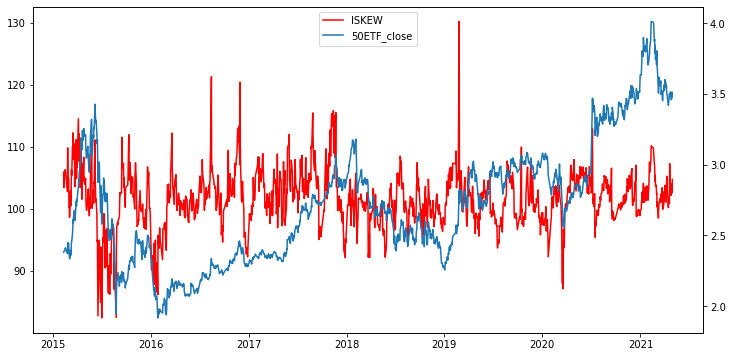

In [261]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
fig1 = ax.plot(data['date'],data['iskew'],'red')
ax2 = ax.twinx()
fig2 = ax2.plot(data['date'],data['close'])
ax.legend(fig1+fig2,['ISKEW','50ETF_close'],loc=9)

2015年2月到2018年4月期间，该程序算得的偏度指数（ISKEW）与中信期货研究所计算结果非常相似。偏度指数总体在90-110的箱体间震荡，振幅相比美国市场较小。

值得关注的是SKEW指数最高点出现在2019年2月25日，也就是大盘飙五个点和网红192倍期权出现的那天。

虽然但是，该程序存在极端暴跌行情下SKEW指数无法计算的问题，该问题尚未得到解决。。。

中信期货研报链接：http://www.doc88.com/p-4334839759676.html

## 隐含偏度、已实现偏度、上证50ETF收益率

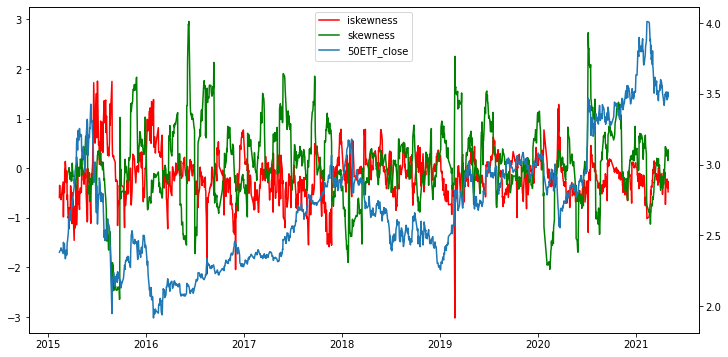

In [264]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
fig1 = ax.plot(data['date'],data['iskewness'],'red')
fig11 = ax.plot(data['date'],data['skewness'],'green')
ax2 = ax.twinx()
fig2 = ax2.plot(data['date'],data['close'])
ax.legend(fig1+fig11+fig2,['iskewness','skewness','50ETF_close'],loc=9)

iskewness表示用SKEW指数反推的风险中性偏度，skewness表示30天已实现偏度

iskewness与skewness总体呈负相关

## 偏度风险溢价与上证50ETF收益率

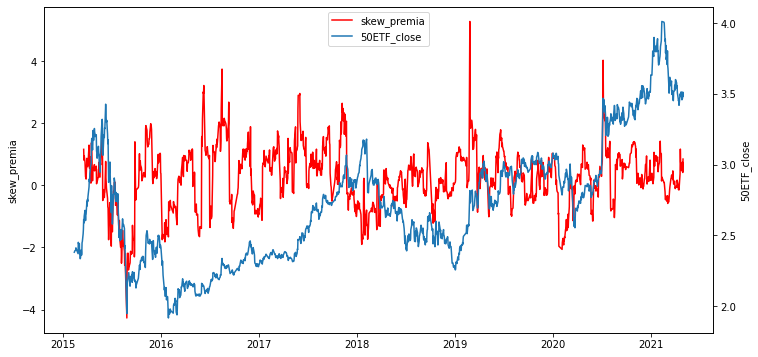

In [263]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
fig1 = ax.plot(data['date'],data['skew_premia'],'red')
ax.set_ylabel('skew_premia')
ax2 = ax.twinx()
fig2 = ax2.plot(data['date'],data['close'])
ax2.set_ylabel('50ETF_close')
ax.legend(fig1+fig2,['skew_premia','50ETF_close'],loc=9)

## 偏度风险溢价的统计性质

In [278]:
print("偏度风险溢价=",data['skew_premia'].mean())
print("t检验结果：",stats.ttest_1samp(data['skew_premia'].dropna(),0))
print("平稳性检验结果：",sm.tsa.stattools.adfuller(reg['skew_premia']))

偏度风险溢价= 0.25268338802385276
t检验结果： Ttest_1sampResult(statistic=10.247534010019447, pvalue=7.468150526070698e-24)
平稳性检验结果： (-5.3184458761629, 5.013916857668066e-06, 24, 1453, {'1%': -3.434858527373781, '5%': -2.8635312133080046, '10%': -2.567830105465636}, 1555.6467632257754)


由此可见，偏度风险溢价显著为正，并且满足平稳性，可以直接用于回归分析，这些性质与陈蓉等（2016）的结论一致。

参考文献：陈蓉, 廖木英, 徐婉菁, 期权隐含偏度风险溢酬：来自中国台湾市场的证据. \[J\] 系统工程理论与实践, 2016.

In [280]:
reg = data.dropna().reset_index(drop=True)
y = reg['ret']
x = reg['skew_premia']
X = sm.add_constant(x)
sm.OLS(y,X).fit(cov_type='HAC',cov_kwds={'maxlags':5}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     28.67
Date:                Sun, 23 May 2021   Prob (F-statistic):           9.96e-08
Time:                        16:41:46   Log-Likelihood:                 4130.6
No. Observations:                1478   AIC:                            -8257.
Df Residuals:                    1476   BIC:                            -8247.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0006      0.000     -1.424      0.154      -0.001       0.000
skew_premia     0.0038      0.001      5.354      0.000       0.002       0.005
==============================================================================
Omnibus:                      561.438   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22711.733
Skew:                          -1.055   Prob(JB):                         0.00
Kurtosis:                      22.088   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

将偏度风险溢价对同期上证50ETF日收益率回归，结果非常显著（表中t值已经过Newey-West修正）

# 下面都是草稿。。

In [185]:
trade_date = '20180706'
interp = get_rf(trade_date)
opt_near,opt_2near = opt_data(trade_date)

In [186]:
cal_S(opt_2near)

-0.0794582620424777

In [171]:
opt_df = opt_near

opt_df_call = opt_df[opt_df['call_put'] == "C"].sort_values(by=['exercise_price']).reset_index(drop=True)
opt_df_put = opt_df[opt_df['call_put'] == "P"].sort_values(by=['exercise_price']).reset_index(drop=True)

opt_df_call = opt_df_call[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'call_close'})
opt_df_put = opt_df_put[['trade_date','call_put','tau','exercise_price','close']].drop_duplicates(['tau','exercise_price'],keep='first').rename(columns={'close':'put_close'})

opt_df_merge = pd.merge(opt_df_call,opt_df_put,on=['tau','exercise_price'])
opt_df_merge['diff_close'] = abs(opt_df_merge['call_close'] - opt_df_merge['put_close'])
S = opt_df_merge[opt_df_merge['diff_close'] == opt_df_merge['diff_close'].min()]['exercise_price'].iloc[0]

tau = opt_df_merge['tau'].unique().tolist()[0]
opt_df_merge['R'] = interp(tau)/100
opt_df_merge['F'] = S + np.exp( opt_df_merge['R'] * (tau/365) )*(opt_df_merge[opt_df_merge['exercise_price'] == S]['call_close'] - opt_df_merge[opt_df_merge['exercise_price'] == S]['put_close']).iloc[0]#.mean()
opt_df_merge['F - Ki'] = opt_df_merge['F'] - opt_df_merge['exercise_price']
try:
    opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'][opt_df_merge['F - Ki']>0].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
except Exception:
    opt_df_merge['K0'] = opt_df_merge[ opt_df_merge['F - Ki'] ==  opt_df_merge['F - Ki'].nsmallest(1).iloc[0]]['exercise_price'].iloc[0]
opt_df_merge['PK'] = opt_df_merge.apply(lambda row: row['call_close'] if row['exercise_price']>row['K0'] else (row['put_close'] if row['exercise_price']<row['K0'] else (row['call_close']+row['put_close'])/2 ),axis=1)
opt_df_merge['K_i+1'] = opt_df_merge['exercise_price'].shift(-1).fillna(opt_df_merge['exercise_price'].iloc[-1])
opt_df_merge['K_i-1'] = opt_df_merge['exercise_price'].shift(1).fillna(opt_df_merge['exercise_price'].iloc[0])
opt_df_merge['delta_K'] = (opt_df_merge['K_i+1'] - opt_df_merge['K_i-1'])/2
opt_df_merge.loc[0,'delta_K'] = opt_df_merge.loc[0,'delta_K']*2
opt_df_merge.loc[len(opt_df_merge)-1,'delta_K'] = opt_df_merge.loc[len(opt_df_merge)-1,'delta_K']*2

F = opt_df_merge['F'].iloc[0]
K0 = opt_df_merge['K0'].iloc[0]

opt_df_merge['p1'] = -np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * opt_df_merge['PK'] * opt_df_merge['delta_K']/(opt_df_merge['exercise_price']**2)
P1 = opt_df_merge['p1'].sum() - ( 1 + np.log(F/K0) - F/K0 )

opt_df_merge['p2'] = np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * 2 * (1-np.log(opt_df_merge['exercise_price']/opt_df_merge['F']))*opt_df_merge['PK'] * opt_df_merge['delta_K']/(opt_df_merge['exercise_price']**2)
P2 = opt_df_merge['p2'].sum() + ( 2 * np.log(K0/F) * (F/K0 - 1) + 0.5 * np.log(K0/F)**2 )

opt_df_merge['p3'] = np.exp(opt_df_merge['R']*opt_df_merge['tau']/365) * 3 * ( 2*np.log(opt_df_merge['exercise_price']/opt_df_merge['F']) - np.power(np.log(opt_df_merge['exercise_price']/opt_df_merge['F']),2) ) * opt_df_merge['PK'] * opt_df_merge['delta_K'] / (opt_df_merge['exercise_price']**2)
P3 = opt_df_merge['p3'].sum() + ( 3 * (np.log(K0/F)**2) * (1/3 * np.log(K0/F) - 1 + F/K0) )

S = (P3 - 3*P1*P2 + 2*P1**3)/np.power((P2 - P1**2),3/2)
# opt_df_merge = opt_df_merge.dropna().reset_index(drop=True)

In [172]:
print(P1)
print(P2)
print(P3)

-0.0020952320858649612
0.004167796350205047
-8.967829962169649e-05


In [173]:
(P3 - 3*P1*P2 + 2*(np.power(P1,3))) / np.power((P2 - P1**2),3/2)

-0.23637144535155855

In [118]:
P1 = -0.00173
P2 = 0.003606
P3 = -0.00049
(P3 - 3*P1*P2 + 2*(np.power(P1,3))) / np.power((P2 - P1**2),3/2)

-2.179191287684384